In [25]:
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from itertools import islice
import matplotlib.pyplot as plt

In [26]:
class KModes:
    def __init__(self, distance, frequency_calculator, sample_frequency, get_centroid, k):
        self.k = k
        self.distance = distance
        self.frequency_calculator = frequency_calculator
        self.sample_frequency = sample_frequency
        self.get_centroid = get_centroid
        
    def fit(self, data):
        self.dataset = data.values.tolist()
        
        # Step 1: Get centroids
        self.centroids = []
        centroids_old = []

        for i in range(self.k):
            centroid = random.choice(self.dataset)

            while centroid in self.centroids:
                centroid = random.choice(self.dataset)

            self.centroids.append(centroid)

        error = np.ones(self.k)
        self.labels = [0 for x in range(len(self.dataset))]

        while error.all() != 0:
            # Step 2: Distance
            # Cluster labels for each point
            self.labels = [0 for x in range(len(self.dataset))]

            # Distances to each centroid
            distances = np.zeros(self.k)

            # Frequency for mode
            frequency = [deepcopy(self.sample_frequency) for x in range(self.k)]

            # Calculate distance to each centroid
            for i in range(len(self.dataset)):
                cluster = -1
                if self.dataset[i] not in self.centroids:
                    for j in range(self.k):
                        distances[j] = self.distance(self.dataset[i], self.centroids[j])

                    cluster = np.argmin(distances)
                else:
                    cluster = self.centroids.index(self.dataset[i])
                    
                self.labels[i] = cluster
                frequency[cluster] = self.frequency_calculator(self.dataset[i], frequency[cluster]) 

            # Step 3: Update centroids
            centroids_old = deepcopy(self.centroids)

            for i in range(self.k):
                proposed_centroid = self.get_centroid(frequency[i])
                temp_centroid = proposed_centroid
                best_distance = 10
                
                for j in range(len(self.dataset)):
                    if self.labels[j] == i:
                        current_dist = distance(proposed_centroid, self.dataset[j])
                        
                        if current_dist < best_distance:
                            temp_centroid = self.dataset[j]
                            best_distance = current_dist
                            
                self.centroids[i] = temp_centroid

                error[i] = self.distance(self.centroids[i], centroids_old[i])

    def inertia(self):
        total_distance = 0.0

        for i in range(self.k):
            """
            cluster_distance = 0.0
            cluster_size = 0
            """
            
            for j in range(len(self.dataset)):
                if self.labels[j] == i:
                    #cluster_distance += self.distance(self.centroids[i], self.dataset[j])
                    #cluster_size += 1
                    total_distance += self.distance(self.centroids[i], self.dataset[j])
                
            #total_distance += cluster_distance/cluster_size

        return total_distance#/(len(self.dataset))
    
    def predict(self, data):
        data_list = data.values.tolist()
        result = [0 for x in range(len(data))]
        
        for i in range(len(data)):
            distances = [0 for x in range(self.k)]
            for j in range(self.k):
                distances[j] = self.distance(data_list[i], self.centroids[j])

            result[i] = np.argmin(distances)
        
        return result
    
    def get_labels(self):
        return self.labels
    
    def get_centroids(self):
        return self.centroids

In [27]:
data = pd.read_csv('ml_data/clustering_data.csv')

info = data[['Author', 'Series', 'Tags']]
info.tail(10)

,Author,Series,Tags
97594,Graham E. Fuller,none,"to-read, language, non-fiction, currently-read..."
97595,Gloria Vanderbilt,none,"to-read, currently-reading, non-fiction, memoi..."
97596,Gloria Vanderbilt,none,"to-read, memoir, biography, currently-reading,..."
97597,Gloria Vanderbilt,none,"to-read, non-fiction, memoir, currently-readin..."
97598,John Farman,none,"to-read, own, non-fiction, history, currently-..."
97599,"Chris Claremont, Brent Anderson",Marvel Graphic Novel,"to-read, comics, graphic-novels, currently-rea..."
97600,"Chris Claremont, Igor Kordey, Salvador Larroca...",X-Treme X-Men (2001) (Collected Editions),"to-read, comics, x-men, graphic-novels, marvel..."
97601,"Frank Morison, Lee Strobel",none,"to-read, currently-reading, christian, apologe..."
97602,Amy Stewart,none,"to-read, science, non-fiction, currently-readi..."
97603,"Abram N. Shulsky, Gary J. Schmitt",none,"to-read, currently-reading, intelligence, non-..."


In [28]:
#Needs work
def individual_distance(a, b):
    a_lst = a.strip('\"').split(', ')
    b_lst = b.strip('\"').split(', ')
    
    total_length = max(len(a_lst), len(b_lst))
    difference = total_length

    for ele in a_lst:
        if ele in b_lst:
            difference -= 1

    return 1.0 * difference/total_length


def distance(book_1, book_2):
    distance = 0.0

    distance += individual_distance(book_1[0], book_2[0])
    distance += individual_distance(book_1[2], book_2[2])

    if book_1[1] != 'none' and book_1[1] == book_2[1]:
        distance += 0.0
    else:
        distance += 1.0

    return distance

def get_frequency(book, cluster):
    authors = book[0].strip('\"').split(', ')

    for author in authors:
        if author in cluster['author']:
            cluster['author'][author] += 1
        else:
            cluster['author'][author] = 1

    if book[1] in cluster['series']:
        cluster['series'][book[1]] += 1
    else:
        cluster['series'][book[1]] = 1
        
    tags = book[2].strip('\"').split(', ')

    for tag in tags:
        if tag in cluster['tags']:
            cluster['tags'][tag] += 1
    else:
        cluster['tags'][tag] = 1

    length = len(tags)

    if length in cluster['length']:
        cluster['length'][length] += 1
    else:
        cluster['length'][length] = 1

    return cluster

def get_centroid(cluster):
    new_centroid = []

    new_centroid.append(max(cluster['author'], key = cluster['author'].get))
    new_centroid.append(max(cluster['series'], key = cluster['series'].get))

    tag_len = max(cluster['length'], key = cluster['length'].get)

    tags_sorted = {k: v for k, v in sorted(cluster['tags'].items(), key=lambda item: item[1])}
    tags = [x[0] for x in islice(tags_sorted.items(), 0, tag_len)]

    new_centroid += tags

    return new_centroid

sample_frequency = {'author': {}, 'series': {}, 'tags': {}, 'length': {}}


In [29]:
info_train, info_test = train_test_split(info, train_size = 0.8, test_size = 0.2, random_state=42)

model = KModes(distance, get_frequency, sample_frequency, get_centroid, 3)
model.fit(info_train)

model.inertia()

224718.96900502744

In [19]:
k_range = range(2, 101)
inertia = []

for k in k_range:
    kmodes_model = KModes(distance, get_frequency, sample_frequency, get_centroid, k)
    kmodes_model.fit(info_train)

    inertia.append(kmodes_model.inertia())

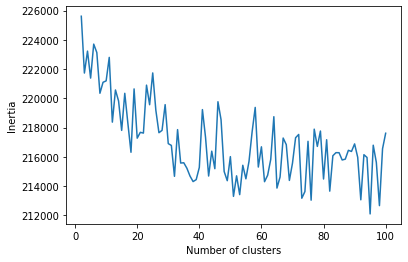

In [23]:
plt.plot(k_range, inertia)

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.show()

In [30]:
model_2 = KModes(distance, get_frequency, sample_frequency, get_centroid, 30)
model_2.fit(info_train)

model_2.inertia()

219573.8393762444

In [31]:
model_2.centroids

[['Neil Gaiman',
  'none',
  'to-read, fantasy, comics, graphic-novels, neil-gaiman, fiction, graphic-novel, own, audio_wanted, vertigo, favorites, owned, sandman, comics-graphic-novels, audio-wanted, books-i-own, comic-books, reference, gaiman, horror, non-fiction, illustrated, currently-reading, graphic-novels-to-read, fantasy-sci-fi, quotes, wishlist, to_read, pop-culture, to-look-for, english, to-read-scifi, other, comic, fiction-fantasy, comics-and-graphic-novels, sff, owned-books, default, sci-fi, series, mythology, hardcover, to-buy, male-author, graphic-novels-comics, gods, boekenkast, wanted, speculative-fic, highly-recommended, allison-s-books, coffee, writing, art, _location-basement, e-books, speculative-fiction, comics-manga-graphic-novels, don-t-own-yet, ll-want_audio, ll-read, current_test, want-to-read, have, manga-graphic-novels, my-books, comics-manga, read-selected, four-star, my-collection, fantasy-sci-fi-horror, owned-books-all, owned-nonfiction, bpl, my-real-books